In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
N_TOT = mnist.train.images.shape[0]

# Since we use logit-normal model make sure
# 0. and 1. done't appear in images by adding/subtracting
# epsilon
mnist.train.images[mnist.train.images == 0.] += 0.001
mnist.train.images[mnist.train.images == 1.] -= 0.001

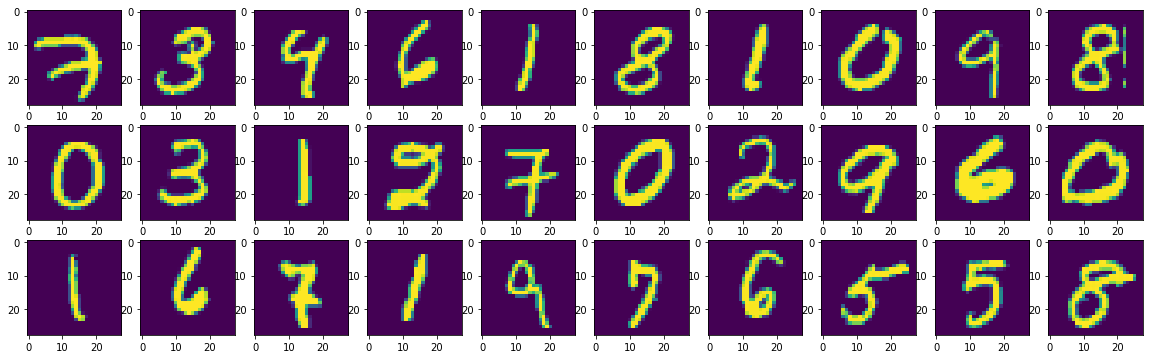

In [3]:
rows, cols = 3, 10
fig, ax = plt.subplots(rows, cols)
for i in range(rows * cols):
    ax[i // 10, i % 10].imshow(mnist.train.images[i, :].reshape([28, 28]))
fig.set_size_inches(2 * cols, 2 * rows)

# Model Parameters and Properties

We are setting up the variational auto-encoding Bayes from [AEVB](https://arxiv.org/pdf/1312.6114.pdf) paper. Where we have a stochastic decoder  $p_{\theta}(x|z)$ and a stochastic encoder $q_{\phi}(z|x)$ and the goal is to optimize the Evidence-Lower Bound (ELBO)

$\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z) + \log p_{\theta}(z)]
+ \mathcal{H}[q_{\phi}(z|x)] = \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)]
- D_{KL}[q_{\phi}(z|x)||p_{\theta}(z)]$

In the following two blocks we set up these encoder/decoder using reparameterized Gaussian densities with diagonal covariance.

- $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), \sigma_{\theta}(z))$ where $\mu_{\theta}(.)$ and $\sigma_{\theta}(.)$ where are MLP functions
- $q_{\phi}(z|x) = \mathcal{N}(\mu_{\phi}(x), \sigma_{\phi}(x))$ where $\mu_{\phi}(.)$ and $\sigma_{\phi}(.)$ where are MLP functions

Also, using [normalizing flows](https://arxiv.org/pdf/1505.05770.pdf) we set up another stochastic encoder where $q(.|.)$ is a several layers of normalizing flows whose parameters are governed by MLP functions.

In the floowing blocks we set up the parameters and architecture of these neural network functions, and set up the flag `NORM_FLWO` to indicate which encoder we use.

In [4]:
from model import ReparameterizedDistribution as ReDist
from transform import MultiLayerPerceptron as MLP
from distribution import LogitNormalDiag
from aevb import AutoEncodingVariationalBayes as vae

STEPS = 20000

BATCH_SIZE = 2
SAMPLE_SIZE = 10

DIM = 28 * 28
LAT_DIM = 5

# The examples that we would like to reconstruct
recon_idx = range(990, 1000)

with tf.Graph().as_default():

    p = ReDist(out_dim=DIM, in_dim=LAT_DIM,
               distribution=tf.contrib.distributions.MultivariateNormalDiag,
               transform=MLP, hidden_units=[64, 128])
    
    q = ReDist(out_dim=LAT_DIM, in_dim=DIM,
               distribution=tf.contrib.distributions.MultivariateNormalDiag,
               transform=MLP, hidden_units=[128, 64])

    prior = tf.contrib.distributions.MultivariateNormalDiag(np.zeros(5), np.ones(5))
    
    v = vae(data=mnist.train.images, generative_model=p, recognition_model=q, prior=prior,
        n_monte_carlo_samples=10, batch_size=2)

    l = v.train(steps=STEPS)
    
    r = v.get_reconstructions(recon_idx)

100%|██████████| 20000/20000 [01:21<00:00, 246.56it/s]


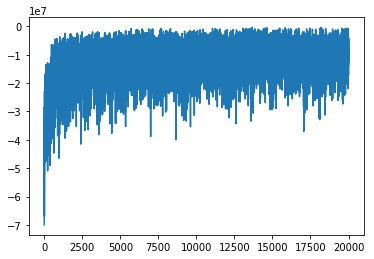

In [5]:
plt.plot(l)

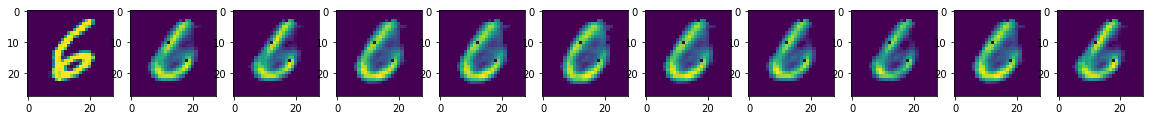

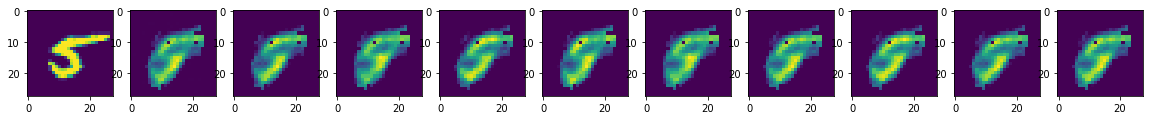

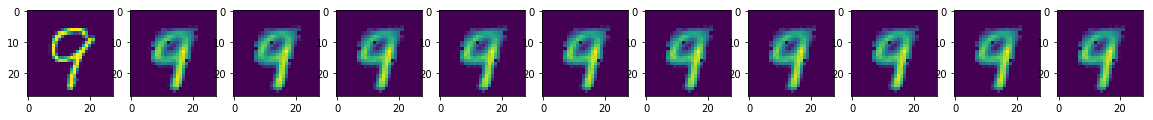

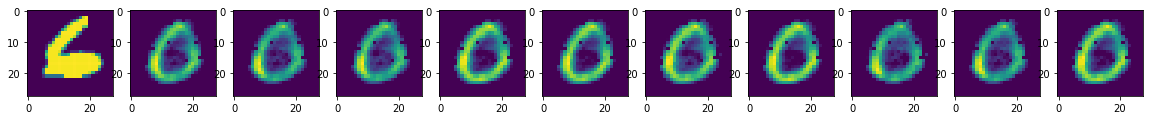

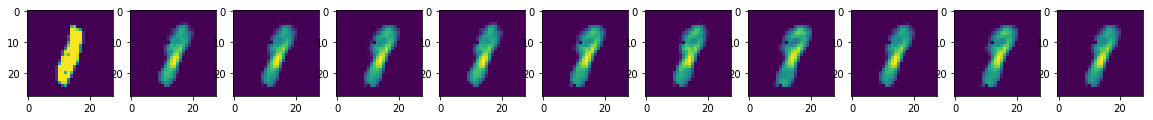

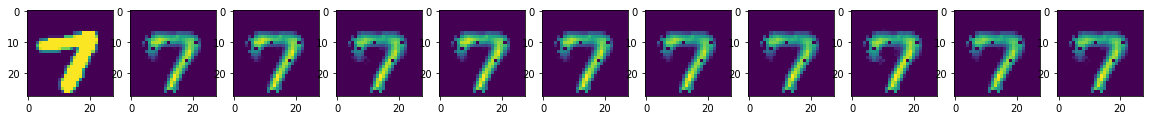

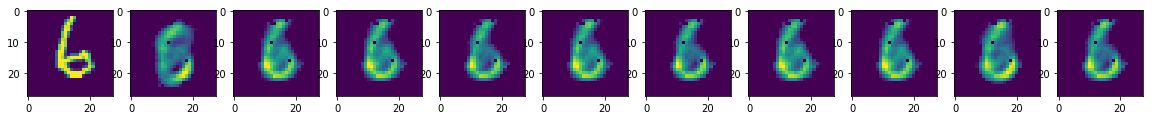

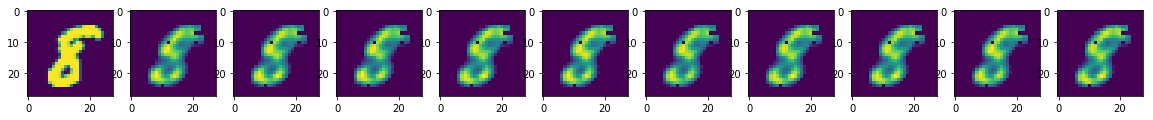

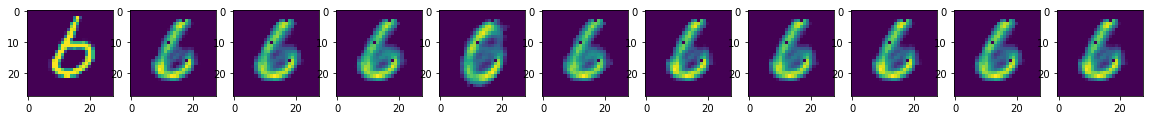

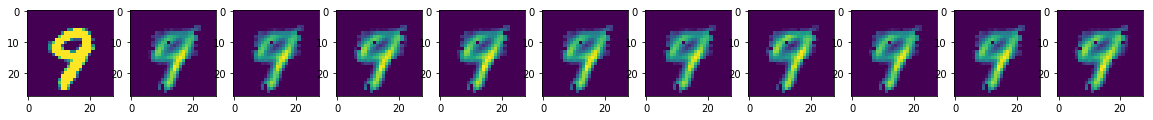

In [6]:
for i, im in enumerate(r):
    fig, ax = plt.subplots(1, 11)
    ax[0].imshow(mnist.train.images[recon_idx[i]].reshape([28, 28]))
    for i in range(10):
        ax[i + 1].imshow(im[i].reshape([28, 28]))
    plt.gcf().set_size_inches(20, 20)
    plt.show()